<br>

---

# UM Hackaton - Rice Disease Classifier (Multiclass Ver)

---
<br>

__Author: AdmiJW__
<br><br>


In the problem statement, the first challenge that we have to tackle is to identify what diseases is affecting the rice from the input.



The classes are:
* Brown Spot
* Healthy
* Leaf Blast 
* Hispa


In this notebook, we'll train a single model that will predict the probability of multiple classes instead.

<br>

---

## 1.0 - Importing Modules

---
<br>


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
print('Importing tensorflow')
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

Importing tensorflow


<br>

---

## 2.0 - Selecting Pretrained Model for Transfer Learning

---
<br>



Here I've loaded several pretrained models, but use them only if necessary.


Run only the one cell that you want to use.

In [2]:
IMG_SHAPE = (300, 300, 3)

### Option 1 - No Pretrained

In [3]:
# If you do not want to use pretrained model, Run this (WIP)
image_preprocessor = lambda x: x

### Option 2 - Inception V3

In [ ]:
# Pretrained model - InceptionV3
inceptionV3_model = tf.keras.applications.inception_v3.InceptionV3(
    include_top=False, 
    weights='imagenet',
    input_shape=IMG_SHAPE
)

pretrained_model = inceptionV3_model
image_preprocessor = tf.keras.applications.inception_v3.preprocess_input
inceptionV3_model.trainable = False

### Option 3 - Mobile Net V2

In [3]:
# Pretrained model - MobileNetV2
mobileNetV2_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                                   include_top = False,
                                                   weights = 'imagenet')

pretrained_model = mobileNetV2_model
image_preprocessor = tf.keras.applications.mobilenet_v2.preprocess_input
mobileNetV2_model.trainable = False

### Option 4 - ResNet50 V2

In [ ]:
# Pretrained model - ResNet50V2
resnet50v2_model = tf.keras.applications.ResNet50V2(
    include_top=False,
    weights="imagenet",
    input_shape=IMG_SHAPE
)

pretrained_model = resnet50v2_model
image_preprocessor = tf.keras.applications.resnet_v2.preprocess_input
resnet50v2_model.trainable = False

### Option 5 - Inception ResNet V2

In [ ]:
# Pretrained Model - InceptionResNetV2
inceptionResNetV2_model = tf.keras.applications.InceptionResNetV2(
    include_top=False,
    input_shape=IMG_SHAPE
)

pretrained_model = inceptionResNetV2_model
image_preprocessor = tf.keras.applications.inception_resnet_v2.preprocess_input
inceptionResNetV2_model.trainable = False

### Option 6 - DenseNet169

In [ ]:
# Pretrained Model - DenseNet169
densenet169_model = tf.keras.applications.DenseNet169(
    include_top=False,
    weights="imagenet",
    input_shape=IMG_SHAPE,
)

pretrained_model = densenet169_model
image_preprocessor = tf.keras.applications.densenet.preprocess_input
densenet169_model.trainable = False

<br>

---

## 3.0 - Dataset

---
<br>

From the directory, we shall have 1600 training images and ~500 validation images.


Load the images using `keras.preprocessing.image.ImageDataGenerator`

In [4]:
IMG_SIZE = (300,300)

In [5]:
# ImageDataGenerator for Data Augmentation
# img_gen = keras.preprocessing.image.ImageDataGenerator(
#     horizontal_flip=True,
#     vertical_flip=True,
#     fill_mode = 'nearest',
#     rotation_range=25,
#     preprocessing_function=image_preprocessor     # This preprocessing function shall perform the rescaling from [0,255]
# )

### Training Dataset

In [12]:
# Training Dataset
TRAIN_DIR = 'datasets/RiceDiseaseDataset/train/Combined'

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    TRAIN_DIR,
    label_mode='categorical',
    image_size=IMG_SIZE,
    seed=123,
    interpolation='nearest'
)

Found 1600 files belonging to 4 classes.


### Validation Dataset

In [13]:
# Validation Dataset
VALIDATION_DIR = 'datasets/RiceDiseaseDataset/validation/Combined'

validate_ds = tf.keras.preprocessing.image_dataset_from_directory(
    VALIDATION_DIR,
    label_mode='categorical',
    image_size=IMG_SIZE,
    seed=123,
    interpolation='nearest'
)


Found 492 files belonging to 4 classes.


### Class Names

In [14]:
class_names = train_ds.class_names

print(class_names)

['BrownSpot', 'Healthy', 'Hispa', 'LeafBlast']


### See Some of The Photos

In [15]:
# Obtain the first batch
for img, label in train_ds.take(1):
    first_batch_images = img
    first_batch_labels = label
    break

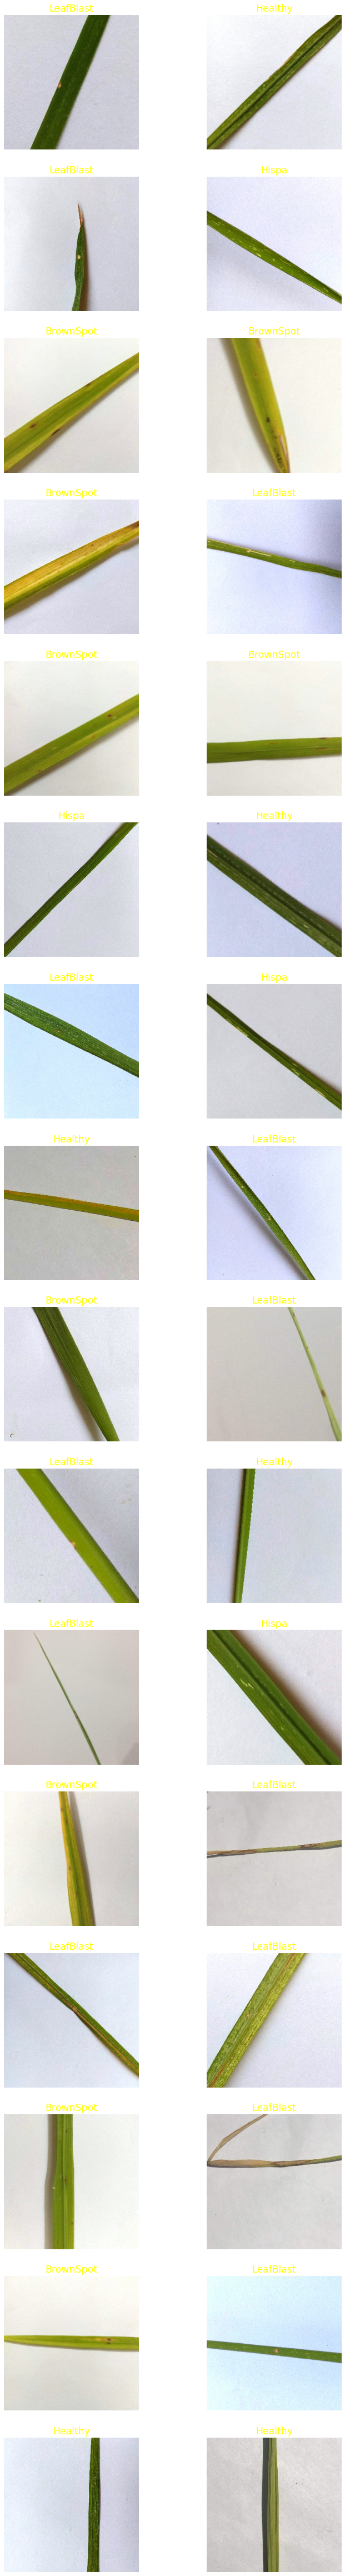

In [16]:
plt.figure(figsize=(12, 90))

# Take 1 batch and show all images
for i in range( len(first_batch_images) ):
    ax = plt.subplot( len(first_batch_images) // 2 + 1, 2, i + 1)
    plt.imshow( first_batch_images[i].numpy() )            # Pass in
    plt.title( class_names[ np.argmax(first_batch_labels[i] ) ], color='yellow', size='xx-large')  # Label with correct class name
    plt.axis("off")

In [17]:
# Check the shape of one batch
print(first_batch_images.shape)                  # (32, 300, 300, 3) - 32 images, 256x256 size, 3 channels
print(first_batch_labels.shape)                 # (32, 4) - 32 labels, each is an array of 4 categories
print( f'Max: { np.amax(first_batch_images[0]) } Min: { np.amin(first_batch_images[0]) }')

(32, 300, 300, 3)
(32, 4)
Max: 255 Min: 0


### Data Augmentation


In [18]:
# Perform random rotation 
rotation_layer = keras.layers.experimental.preprocessing.RandomRotation(3)  # 3 radians

train_ds = train_ds.map(lambda x, y: (rotation_layer(x), y))

In [19]:
# Perform random flipping
flipping_layer = keras.layers.experimental.preprocessing.RandomFlip()

train_ds = train_ds.map(lambda x, y: (flipping_layer(x), y))

### Check out the Augmented Data (Rotated, Flipped)

In [20]:
# Obtain the first batch
for img, label in train_ds.take(1):
    first_batch_images = img
    first_batch_labels = label
    break

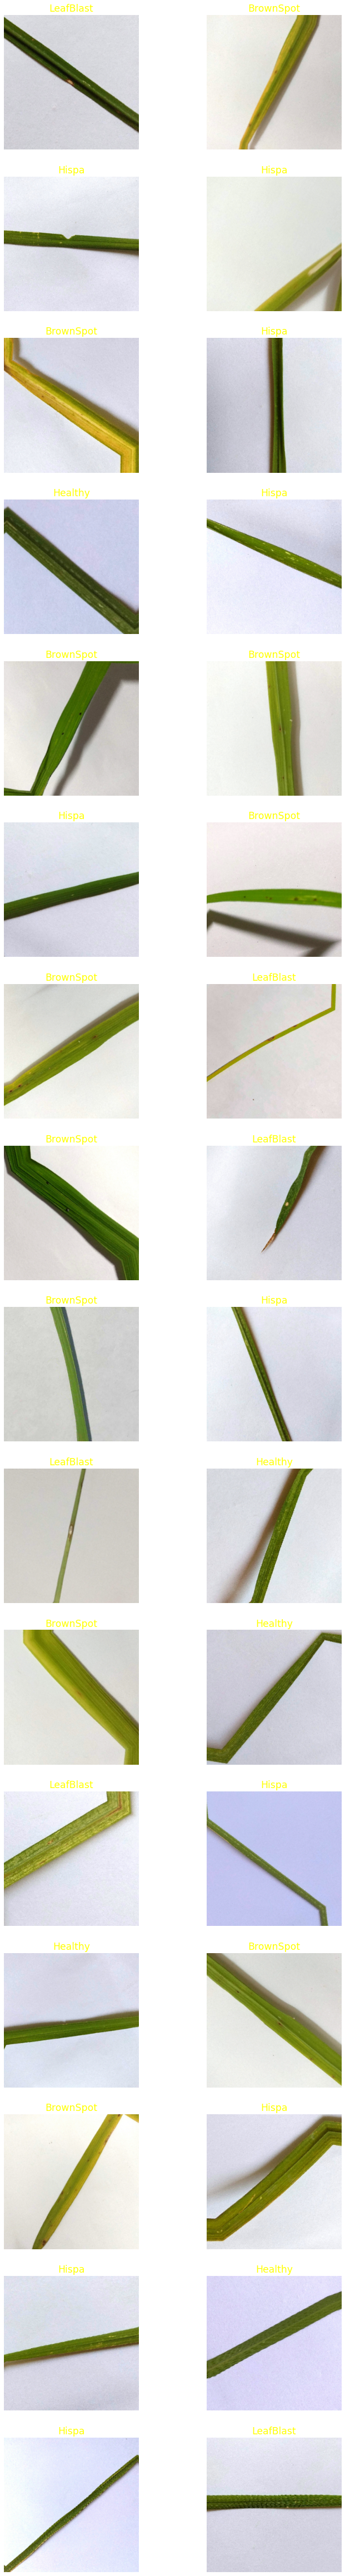

In [21]:
plt.figure(figsize=(12, 90))

# Take 1 batch and show all images
for i in range( len(first_batch_images) ):
    ax = plt.subplot( len(first_batch_images) // 2 + 1, 2, i + 1)
    plt.imshow( first_batch_images[i].numpy() )            # Pass in
    plt.title( class_names[ np.argmax(first_batch_labels[i] ) ], color='yellow', size='xx-large')  # Label with correct class name
    plt.axis("off")

### Normalize Training Dataset to [-1,1] 

In [22]:
# Normalize Training Dataset to be in range [-1,1]
rescaling_layer = keras.layers.experimental.preprocessing.Rescaling(1./127.5, offset=-1)

train_ds = train_ds.map(lambda x, y: (rescaling_layer(x), y))
validate_ds = validate_ds.map(lambda x, y: (rescaling_layer(x), y))

# You can see the range of image value is now -1 to 1 only
for img_batch, label_batch in train_ds.take(1):
    print(np.min(img_batch[0]), np.max(img_batch[0]))
    break


-1.0 1.0


### Cache for Faster Processing (Not Compatible with Directory Iterator)

In [23]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
validate_ds = validate_ds.cache().prefetch(buffer_size=AUTOTUNE)

<br>

---

## 4.0 - Building the Model

---
<br>

### Classification Model

In [24]:
# The learning rate determines how much we're allowed to change the weights and biases
# of the model. Use small learning rate because we are using a already pre trained model
base_learning_rate = 0.001

In [19]:
# Classification Model.
# Remember the last layer shall be same number of tensor as the number of classes
model = keras.Sequential([
    keras.layers.InputLayer(input_shape=IMG_SHAPE),
    pretrained_model,                                  # Pretrained model
    keras.layers.GlobalAveragePooling2D(),
    keras.layers.Dropout(rate=0.55),
    layers.Dense(256, activation='relu'),
    layers.Dense( len(class_names), activation='softmax')        
])



model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
    loss=tf.keras.losses.CategoricalCrossentropy(),      # Categorical Cross Entropy Loss function
    metrics=['accuracy']
)

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 10, 10, 1280)      2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               327936    
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 1028      
Total params: 2,586,948
Trainable params: 328,964
Non-trainable params: 2,257,984
_________________________________________________________________


<br>

---

## 5.0 - Training The Model

---
<br>

In [25]:
# Check if your training is utilizing GPU
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [20]:
# Make the pretrained model to be trainable
pretrained_model.trainable = False

### Data Augment every 5 Epochs

In [28]:
pretrained_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 300, 300, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 150, 150, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 150, 150, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 150, 150, 32) 0           bn_Conv1[0][0]                   
_______________________________________________________________________________

In [34]:
# Augment the data again. Run this cell everytime you want to augment the data
def augment_dataset():
    global train_ds
    train_ds = tf.keras.preprocessing.image_dataset_from_directory(
        TRAIN_DIR,
        label_mode='categorical',
        image_size=IMG_SIZE,
        seed=123,
        interpolation='nearest'
    )

    train_ds = train_ds.map(lambda x, y: (flipping_layer(x), y))
    train_ds = train_ds.map(lambda x, y: (rotation_layer(x), y))
    train_ds = train_ds.map(lambda x, y: (rescaling_layer(x), y))

    train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)

### Training The Model

In [29]:
# Training the model
epochs = 100
augment_every_round = 5
rounds = epochs // augment_every_round

# Callback to save model file
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath='trained_models/um_combined_model.h5',
    save_weights_only=False,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True
)

histories = []

for i in range(rounds):
    print(f"Round {i+1}/{rounds}")

    history = model.fit(
        train_ds,
        validation_data=validate_ds,
        epochs=augment_every_round,
        callbacks=model_checkpoint
    )
    histories.append(history)
    
    print("Augmenting Dataset")
    augment_dataset()

Round 1/20
Epoch 1/5
50/50 [==============================] - 244s 2s/step - loss: 0.8393 - accuracy: 0.6288 - val_loss: 1.0037 - val_accuracy: 0.5691
Epoch 2/5
50/50 [==============================] - 96s 2s/step - loss: 0.8271 - accuracy: 0.6344 - val_loss: 1.0068 - val_accuracy: 0.5671
Epoch 3/5
50/50 [==============================] - 87s 2s/step - loss: 0.7974 - accuracy: 0.6531 - val_loss: 1.0195 - val_accuracy: 0.5711
Epoch 4/5
50/50 [==============================] - 12s 239ms/step - loss: 0.7955 - accuracy: 0.6525 - val_loss: 1.0112 - val_accuracy: 0.5813
Epoch 5/5
50/50 [==============================] - 12s 235ms/step - loss: 0.7737 - accuracy: 0.6619 - val_loss: 1.0183 - val_accuracy: 0.5732
Augmenting Dataset
Found 1600 files belonging to 4 classes.
Round 2/20
Epoch 1/5
50/50 [==============================] - 135s 238ms/step - loss: 0.8163 - accuracy: 0.6562 - val_loss: 1.0088 - val_accuracy: 0.5528
Epoch 2/5
50/50 [==============================] - 12s 236ms/step - loss:

### Training Result

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

<br>

---

## 6.0 - Training Top Layers of Pretrained Model (Fine Tuning)

---
<br><br>

Do this only after the top layer is trained.

Reference [__HERE__](https://www.tensorflow.org/tutorials/images/transfer_learning#fine_tuning)

### Loading Model (NOT FINE TUNED)

In [52]:
# Load from the trained model from previous (NOT FINE TUNED) model
model = tf.keras.models.load_model('trained_models/um_combined_model.h5')

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 10, 10, 1280)      2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               327936    
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 1028      
Total params: 2,586,948
Trainable params: 328,964
Non-trainable params: 2,257,984
_________________________________________________________________


### Loading Model (ALREADY FINE TUNED)

In [53]:
## Load from the trained model from previous (FINE TUNED) model
model = tf.keras.models.load_model('trained_models/um_combined_tuned_model.h5')

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 10, 10, 1280)      2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               327936    
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 1028      
Total params: 2,586,948
Trainable params: 2,072,132
Non-trainable params: 514,816
_________________________________________________________________


In [54]:
# Check the accuracy
model.evaluate(validate_ds)

16/16 [==============================] - 4s 173ms/step - loss: 1.3941 - accuracy: 0.6789


[1.3940640687942505, 0.6788617968559265]

In [55]:
# Obtain the pretrained model 
pretrained_model = model.get_layer(index=0)

In [56]:
# Make the pretrained model to be trainable
pretrained_model.trainable = True

In [57]:
# Let's take a look to see how many layers are in the base model
print("# Layers in pretrained model: ", len(pretrained_model.layers) )

# Fine-tune from this layer onwards
fine_tune_at = 100
print(f"Will train all the layers from {fine_tune_at} onwards")

# Freeze all the layers before the `fine_tune_at` layer,
for layer in pretrained_model.layers[:fine_tune_at]:
  layer.trainable =  False

# Layers in pretrained model:  154
Will train all the layers from 100 onwards


In [58]:
# Compile the model again with much lower learning rate.
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate/200), # Reduced learning rate
    loss=tf.keras.losses.CategoricalCrossentropy(),      # Categorical Cross Entropy Loss function
    metrics=['accuracy']
)

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 10, 10, 1280)      2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               327936    
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 1028      
Total params: 2,586,948
Trainable params: 2,190,404
Non-trainable params: 396,544
_________________________________________________________________


In [59]:
# Training the model
epochs = 100
augment_every_round = 5
rounds = epochs // augment_every_round

# Callback to save model file
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath='trained_models/um_combined_tuned_model.h5',
    save_weights_only=False,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True
)

histories = []

for i in range(rounds):
    print(f"Round {i+1}/{rounds}")

    history = model.fit(
        train_ds,
        validation_data=validate_ds,
        epochs=augment_every_round,
        callbacks=model_checkpoint
    )
    histories.append(history)
    
    print("Augmenting Dataset")
    augment_dataset()

Round 1/20
Epoch 1/5
50/50 [==============================] - 19s 324ms/step - loss: 0.6395 - accuracy: 0.7638 - val_loss: 1.3712 - val_accuracy: 0.6728
Epoch 2/5
50/50 [==============================] - 15s 309ms/step - loss: 0.5197 - accuracy: 0.8000 - val_loss: 1.3600 - val_accuracy: 0.6606
Epoch 3/5
50/50 [==============================] - 15s 309ms/step - loss: 0.4586 - accuracy: 0.8263 - val_loss: 1.3550 - val_accuracy: 0.6606
Epoch 4/5
50/50 [==============================] - 15s 310ms/step - loss: 0.4173 - accuracy: 0.8269 - val_loss: 1.3615 - val_accuracy: 0.6707
Epoch 5/5
50/50 [==============================] - 15s 311ms/step - loss: 0.4091 - accuracy: 0.8331 - val_loss: 1.3639 - val_accuracy: 0.6606
Augmenting Dataset
Found 1600 files belonging to 4 classes.
Round 2/20
Epoch 1/5
50/50 [==============================] - 123s 310ms/step - loss: 0.5818 - accuracy: 0.7862 - val_loss: 1.3457 - val_accuracy: 0.6606
Epoch 2/5
50/50 [==============================] - 15s 308ms/step

<br>

---

## 7.0 - Saving Models

---
<br>


Remember that when loading in the models, we need to preprocess the images so that the image are in range of (0,1) and not (0,255)

In [ ]:
model.save('trained_models/um_combined_model.h5')

In [ ]:
model.save('trained_models/um_combined_tuned_mode.h5')